In [1]:
import torch
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, DSTFTabs, DSTFTenergy

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("mps")
print(device, torch.__version__)
torch.manual_seed(1802)

cpu 2.6.0


In [2]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

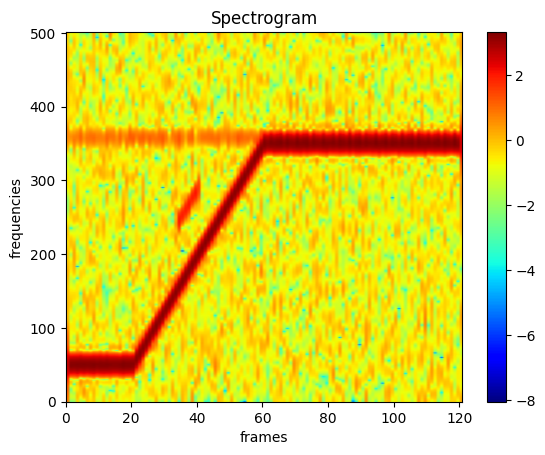

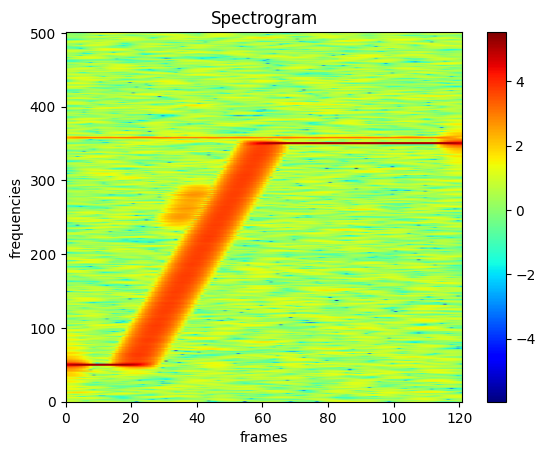

In [15]:
for winlen in [100, 1_000]:
    dstft = DSTFT(
        x,
        win_length=winlen,
        support=1000,
        stride=50,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, *_ = dstft(x)
    dstft.plot(spec, x, bar=True, wins=False, weights=False)

This is how the results look using the code currently on the github

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/DSTFT/dstft/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


lambda_reg 0.0
72


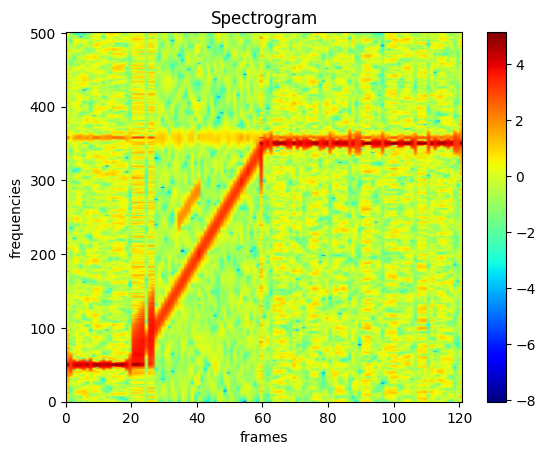

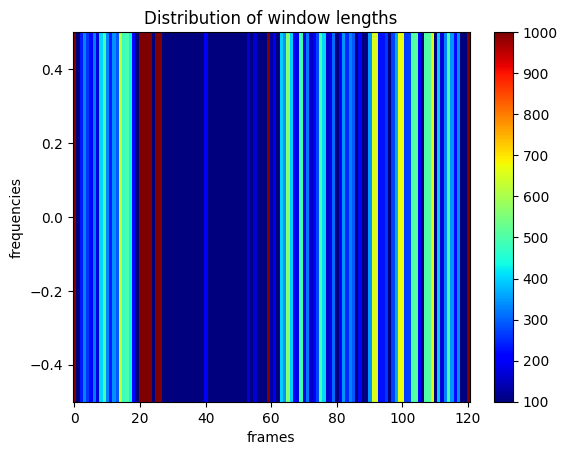

lambda_reg 0.001
88


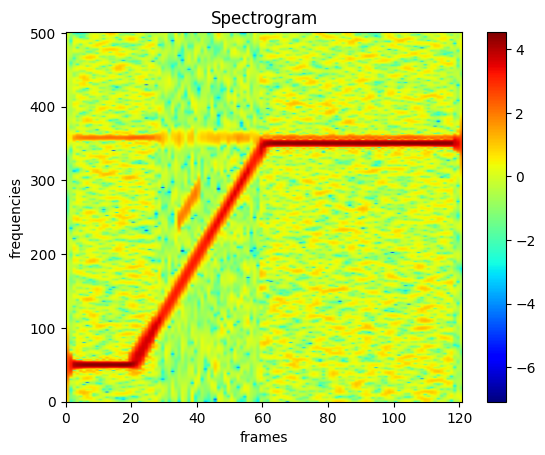

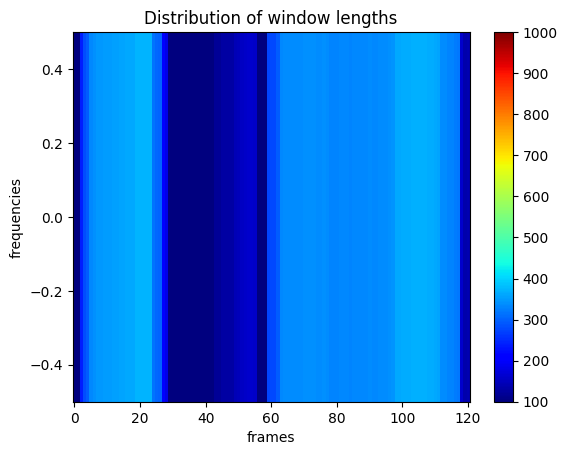

lambda_reg 0.01
30


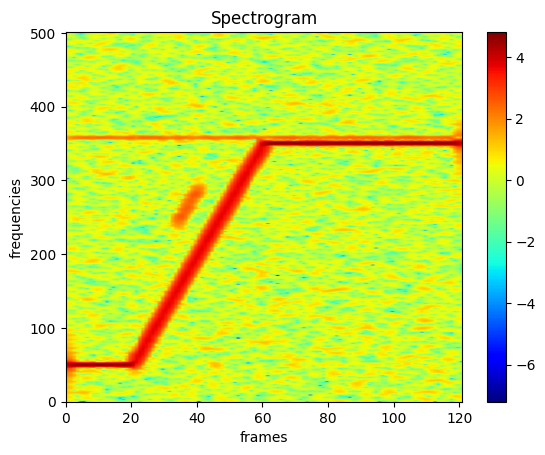

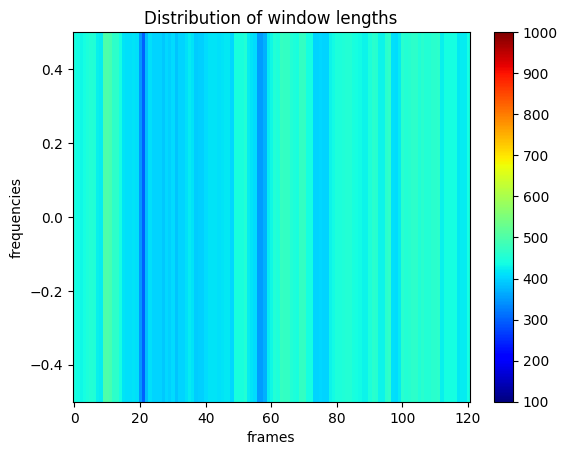

lambda_reg 0.1
30


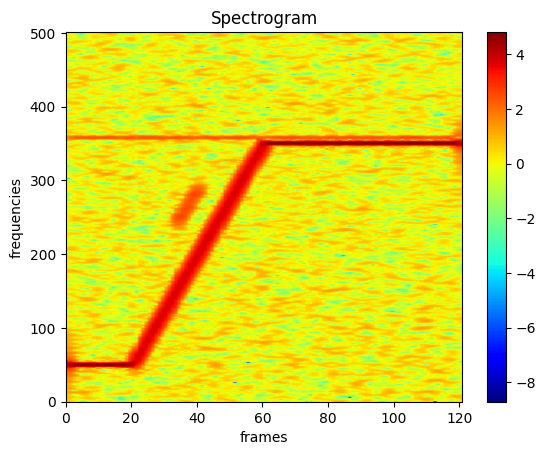

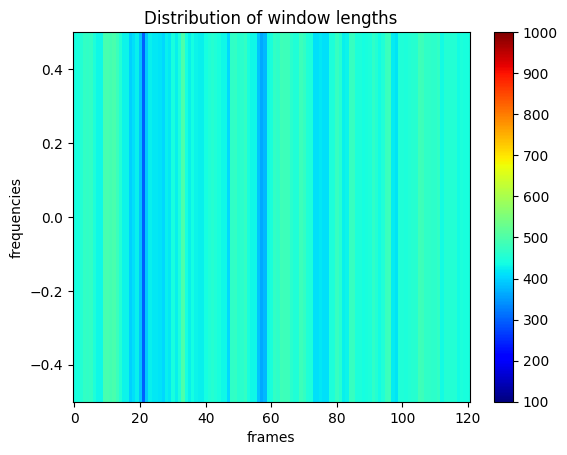

In [19]:
for lambda_reg in [0.0, 0.001, 0.01, 0.1]:
    dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100
               ).to(device)
    params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    print("lambda_reg", lambda_reg)
    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x)
        err = entropy_loss(spec) + lambda_reg * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
        err.backward()
        opt.step()
        sch.step(err)

        """toolong = (dstft.win_length > 1000).sum()
        if toolong > 0:
            print("too long", toolong)
        tooshort = (dstft.win_length < 50).sum()
        if tooshort > 0:
            print("too short", tooshort)"""
        with torch.no_grad():
            dstft.win_length.copy_(torch.clamp(dstft.win_length, min=50, max=1000))
        
        if opt.param_groups[0]['lr'] < 1:
            break
    
    print(epoch)
    spec, *_ = dstft(x)
    #print(entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean())
    dstft.plot(spec, x, bar=True, wins=False, weights=True)
    #weights = dstft.win_length

This is how the results look after I have added back the window integral normalization that was removed. They now reproduce the paper results.

lambda_reg 0.0
47


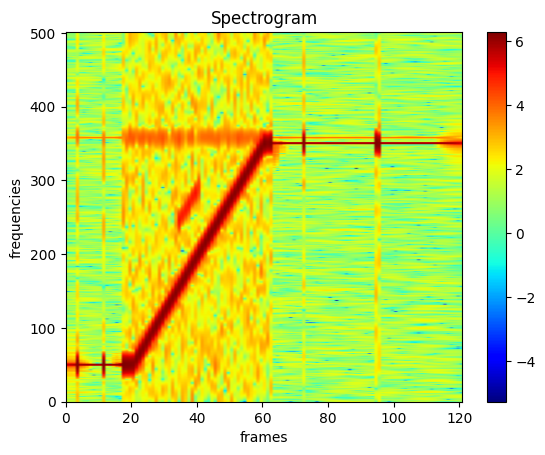

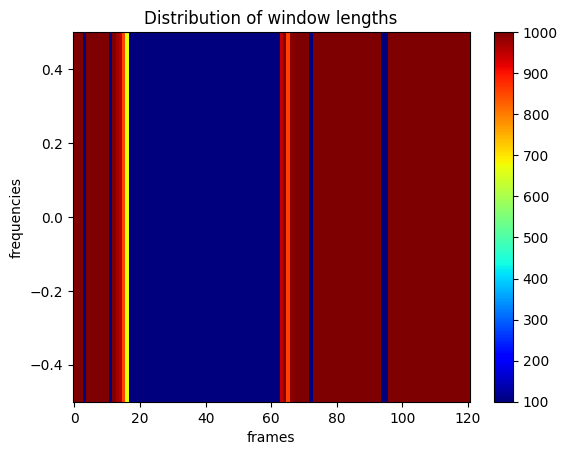

lambda_reg 0.001
61


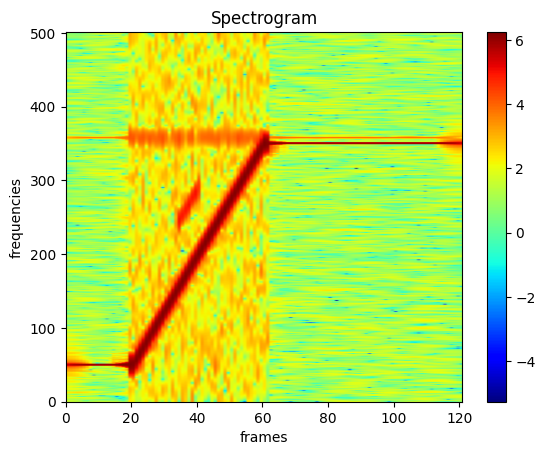

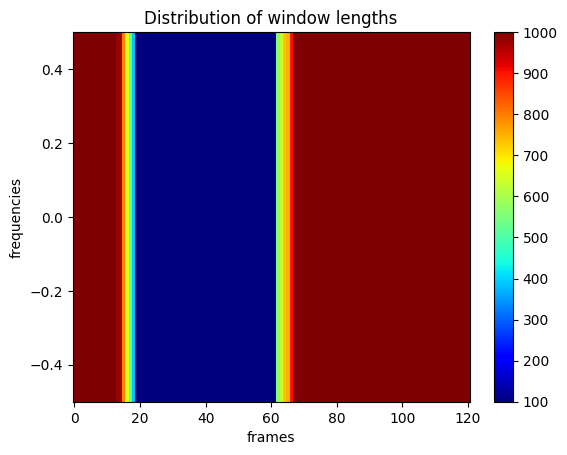

lambda_reg 0.01
30


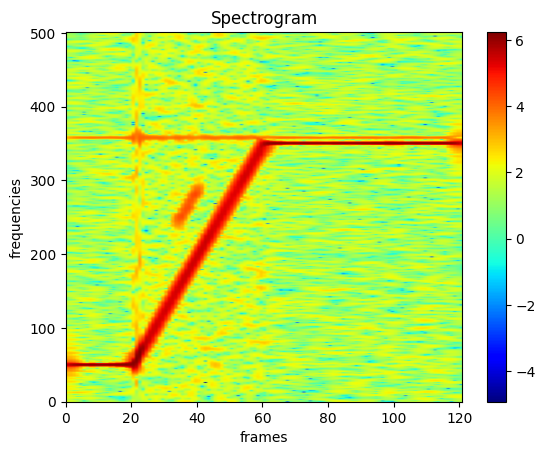

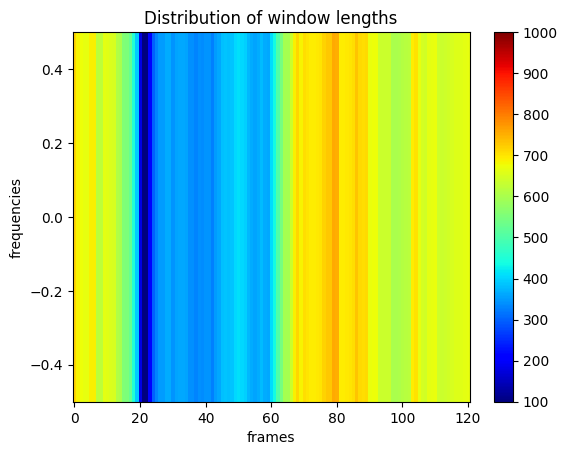

lambda_reg 0.1
30


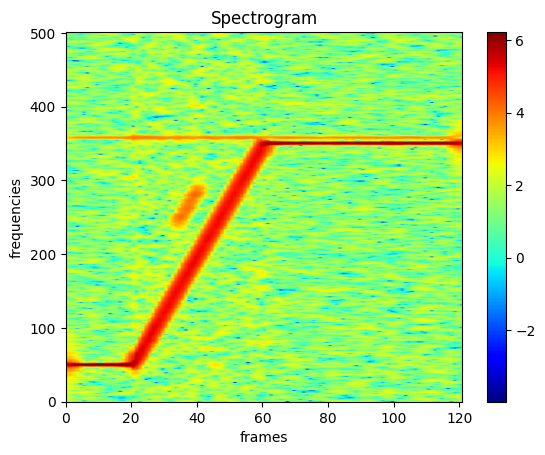

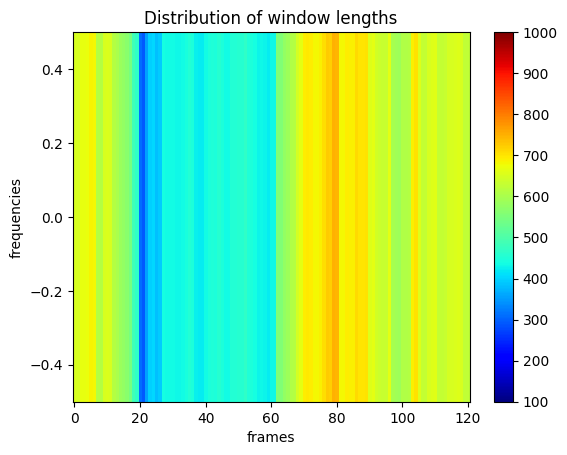

In [17]:
for lambda_reg in [0.0, 0.001, 0.01, 0.1]:
    dstft = DSTFTabs(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100
               ).to(device)
    params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    print("lambda_reg", lambda_reg)
    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x)
        err = entropy_loss(spec) + lambda_reg * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
        err.backward()
        opt.step()
        sch.step(err)

        """toolong = (dstft.win_length > 1000).sum()
        if toolong > 0:
            print("too long", toolong)
        tooshort = (dstft.win_length < 50).sum()
        if tooshort > 0:
            print("too short", tooshort)"""
        with torch.no_grad():
            dstft.win_length.copy_(torch.clamp(dstft.win_length, min=50, max=1000))
        
        if opt.param_groups[0]['lr'] < 1:
            break
    
    print(epoch)
    spec, *_ = dstft(x)
    #print(entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean())
    dstft.plot(spec, x, bar=True, wins=False, weights=True)
    #weights = dstft.win_length

This is how the results look after I change the normalization to be energy-based instead of window integral, and calculate errors on the power spectrum instead of the magnitude spectrum. We see an improvement in robustness to the choice of regularization factor.

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/DSTFT/dstft/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


lambda_reg 0.0
34
tensor(6.8220, grad_fn=<AddBackward0>)


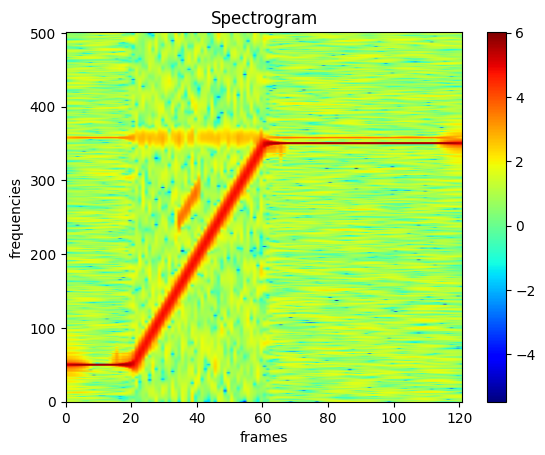

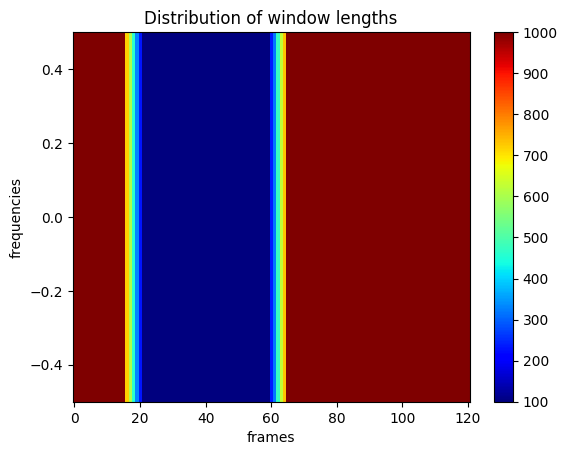

lambda_reg 0.001
68
tensor(6.8150, grad_fn=<AddBackward0>)


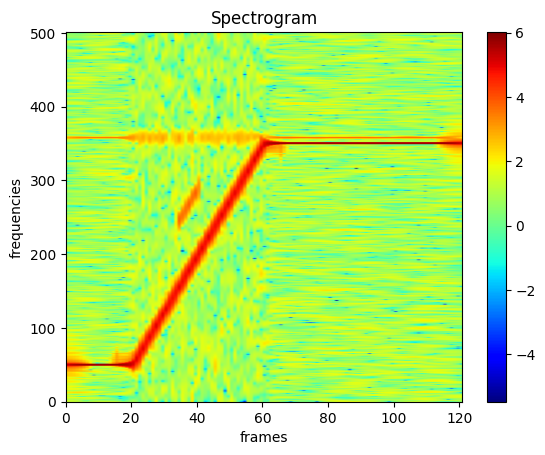

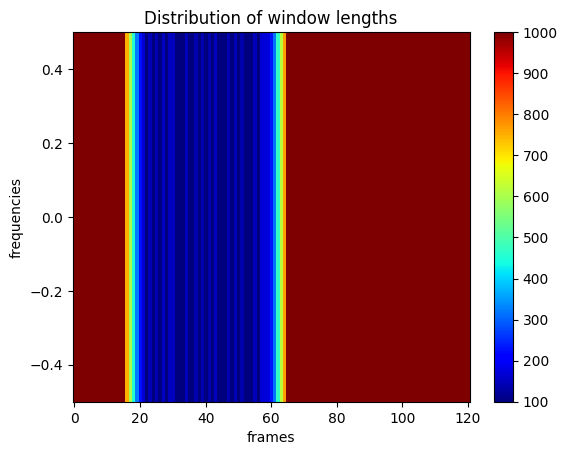

lambda_reg 0.01
237
tensor(6.9408, grad_fn=<AddBackward0>)


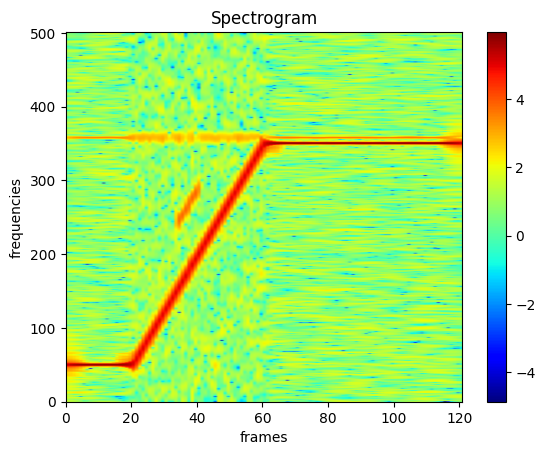

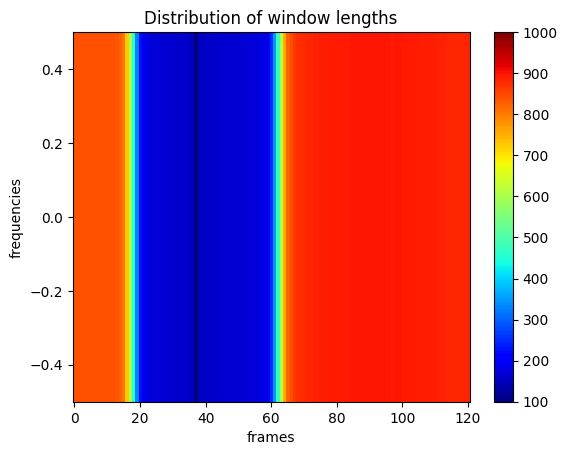

lambda_reg 0.1
30
tensor(8.7134, grad_fn=<AddBackward0>)


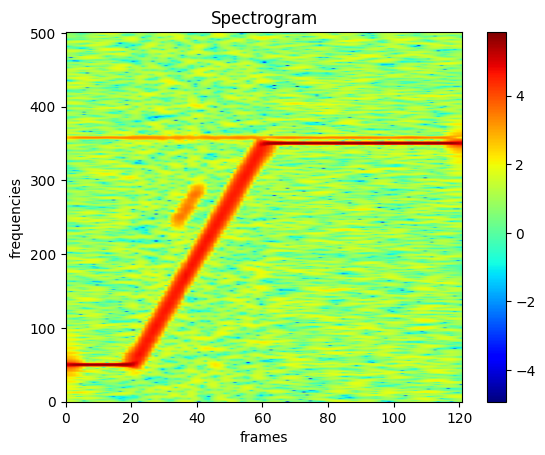

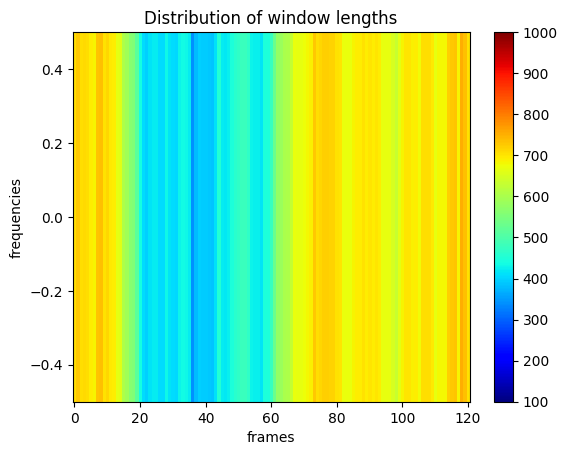

In [3]:
for lambda_reg in [0.0, 0.001, 0.01, 0.1]:
    dstft = DSTFTenergy(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100
               ).to(device)
    params = [{'params': dstft.win_length,'lr': 100.0}] #[{'params': dstft.win_length,'lr': 100.0}]#, {'params': dstft.strides,    'lr': 1.0}] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    print("lambda_reg", lambda_reg)
    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x)
        err = entropy_loss(spec) + lambda_reg * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
        err.backward()
        opt.step()
        sch.step(err)

        """toolong = (dstft.win_length > 1000).sum()
        if toolong > 0:
            print("too long", toolong)
        tooshort = (dstft.win_length < 50).sum()
        if tooshort > 0:
            print("too short", tooshort)"""
        #with torch.no_grad():
        #    dstft.win_length.copy_(torch.clamp(dstft.win_length, min=50, max=1000))
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(epoch)
    spec_abs, *_ = dstft.abs_forward(x)
    spec, *_ = dstft.forward(x)
    print(entropy_loss(spec) + lambda_reg * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean())
    dstft.plot(spec_abs, x, bar=True, wins=False, weights=True)
    #dstft.win_length = weights
    #spec, *_ = dstft(x)
    #print(entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean())